In [1]:
import sys
from pathlib import Path

import pandas as pd

TOP_DIR = Path('../../../..').resolve()

if str(TOP_DIR) not in sys.path: sys.path.append(str(TOP_DIR))

In [2]:
from lib.util.geo import postcode_formatter, postcode_to_ward_code

In [3]:
ticket_data = pd.read_csv(
    '../../../../working/metrics/ticketing/orders.csv',
    parse_dates=['created_at', 'event_date'],
    usecols=[
        'created_at',
        'event_id',
        'event_name',
        'event_date',
        'event_time',
        'number_of_tickets',
        'postcode_from_question',
        'postcode_from_address',
        'status',
    ]
)

In [4]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6766 entries, 0 to 6765
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   postcode_from_question  6384 non-null   object        
 1   postcode_from_address   854 non-null    object        
 2   created_at              6766 non-null   datetime64[ns]
 3   event_id                6766 non-null   object        
 4   event_name              6766 non-null   object        
 5   event_date              6766 non-null   datetime64[ns]
 6   event_time              6766 non-null   object        
 7   number_of_tickets       6766 non-null   int64         
 8   status                  6766 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 475.9+ KB


In [5]:
completed_orders = (
    ticket_data.loc[
        ~ticket_data.status.isin(['cancelled']),
        ticket_data.columns
    ]
)

In [6]:
completed_orders['ward_code'] = (
    completed_orders
        .loc[:, ['postcode_from_question', 'postcode_from_address']]
        .bfill()
        .iloc[:, 0]
        .pipe(postcode_formatter)
        .map(postcode_to_ward_code)
)

Get the events data

In [7]:
def prepare_events(data: pd.DataFrame):
    data = data.rename(columns={
        'Project name': 'project_name',
        'Event type': 'event_type',
        'Ticket Tailor ID': 'ticket_tailor_id'
    })
    data['public_event'] = data.event_type.str.contains('Public Event')
    data['ticket_tailor_id'] = data.ticket_tailor_id.str.split(
        pat=r'[\s,]+', regex=True)
    data = data.drop(columns=['event_type'])
    data = data.explode('ticket_tailor_id')
    data = data.loc[data.ticket_tailor_id.notna() & (data.ticket_tailor_id != '')]
    return data


events = pd.read_csv(
    '../../../../working/metrics/events/all.csv',
    usecols=[
        'Project name',
        'Event type',
        'Ticket Tailor ID'
    ]
).pipe(prepare_events)

Duplicated ticket tailor IDs

In [8]:
events[
  events.ticket_tailor_id.isin(
    events.ticket_tailor_id[
      events.ticket_tailor_id.duplicated()
    ].to_list()
  )
]

,project_name,ticket_tailor_id,public_event
130,11 - All That Lives,985872,True
149,09 - Smeaton300: Moon Palace East Leeds Observ...,ev_2918127,True
175,11 - All That Lives,985872,True
271,Creative Learning S3,ev_3073624,False
333,11 - All That Lives,985872,True
647,11 - All That Lives,985872,True
940,07 - Children's Day,ev_2963290,NaN
940,07 - Children's Day,ev_2963290,NaN
940,07 - Children's Day,ev_2963295,NaN
940,07 - Children's Day,ev_2963297,NaN


In [9]:
len(completed_orders)

6593

In [10]:
completed_orders = completed_orders.merge(
    events.drop_duplicates().set_index('ticket_tailor_id'),
    left_on='event_id',
    right_index=True,
    how='left'
)

In [11]:
len(completed_orders)

6601

In [12]:
OUTPUT_DIR = TOP_DIR.joinpath('data/metrics/events/tickets/')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
completed_orders.loc[:, [
    'created_at',
    'event_id',
    'event_date',
    'number_of_tickets',
    'ward_code',
    'project_name',
    'public_event',
]].sort_values(['created_at', 'event_id']).to_csv(
  OUTPUT_DIR.joinpath('orders.csv'),
  index=False
)

In [14]:
(
    completed_orders.loc[:, ['event_date', 'event_time', 'event_name', 'event_id', 'project_name', 'public_event']]
      .drop_duplicates()
      .sort_values(['event_date', 'event_time'])
      .to_csv('../../../../data/metrics/events/tickets/events.csv', index=False)
)

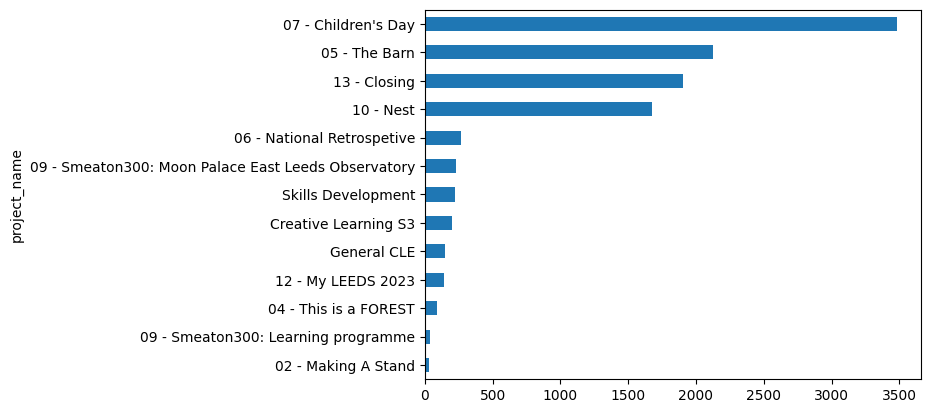

In [15]:
chart = completed_orders.groupby(['project_name']).number_of_tickets.sum().sort_values().plot.barh()

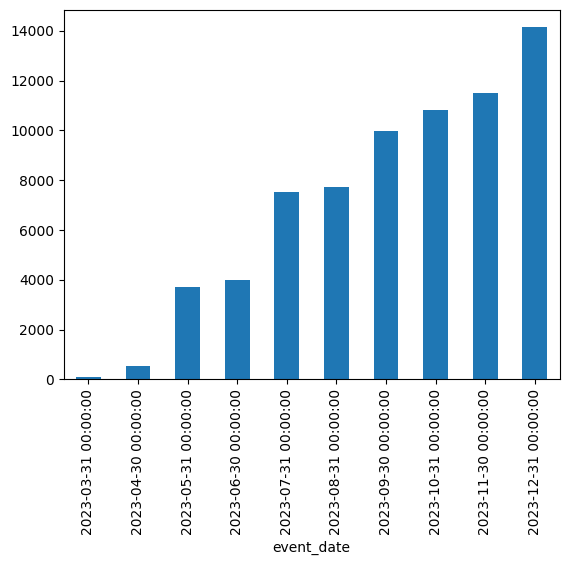

In [16]:
chart = completed_orders.groupby([
    'event_date'
    ]).number_of_tickets.sum().resample('M').sum().cumsum().plot.bar()